Students  
* 0001121701 - Michele Carusone - michele.carusone@studio.unibo.it  
* 0001124192 - Mohd Shariq Ansari - mohdshariq.ansari@studio.unibo.it

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

## Track A

Let's first import the main libraries

In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from copy import copy

and store all the images in 2 lists, one for the scenes and one for the reference models.

In [3]:
models = []
scenes = []
for i in range(1, 28):
    img_mod = cv2.imread('dataset/models/ref' + str(i) + '.png', 1)
    img_mod = cv2.cvtColor(img_mod, cv2.COLOR_BGR2RGB)
    models.append(img_mod)
for i in range(1, 13):
    img_scene = cv2.imread('dataset/scenes/scene' + str(i) + '.png', 1)
    img_scene = cv2.cvtColor(img_scene, cv2.COLOR_BGR2RGB)
    scenes.append(img_scene)

#### Denoising  
All the scenes have salt and pepper noise. After trying several denoising approaches, the one that gave the best results was a combination of 3 filters: a median filter, a gaussian one and a non-local means filter.

In [4]:
denoised_scenes = []
for scene in scenes:
    scene = cv2.medianBlur(scene, 5)
    scene = cv2.GaussianBlur(scene, (5, 5) , 1)
    scene = cv2.fastNlMeansDenoisingColored(scene, h=12, hColor=12, templateWindowSize=7, searchWindowSize=21)
    denoised_scenes.append(scene)

An edge sharpening step is performed after denoising to restore edges' sharpness. This step proved to slightly increase the performance of the system.

In [5]:
sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
sharpened_scenes = []
for scene in denoised_scenes:
    scene = cv2.filter2D(scene, -1, sharpen_filter)
    sharpened_scenes.append(scene)

Let's show a scene denoising and sharpening.

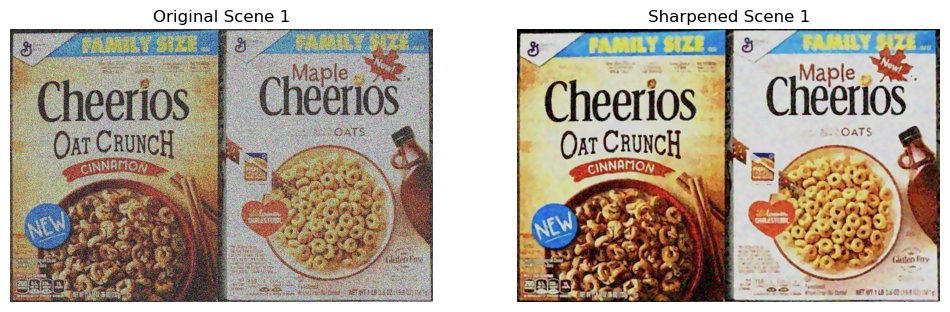

In [6]:
plt.figure(figsize=(12, 6))

# Original scene
plt.subplot(1, 2, 1)
plt.imshow(scenes[0])
plt.title('Original Scene 1')
plt.axis('off')

# Sharpened scene
plt.subplot(1, 2, 2)
plt.imshow(sharpened_scenes[0])
plt.title('Sharpened Scene 1')
plt.axis('off')

plt.show()

#### Object detection 


Let's implement the object detection pipeline.

In [7]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

In [ ]:
# Store the keypoints and descriptors for all scenes and models in 2 separate lists
kp_des_models = []
kp_des_scenes = []
for scene in sharpened_scenes:
    kp_des_scenes.append(sift.detectAndCompute(scene, None))
for model in models:
    kp_des_models.append(sift.detectAndCompute(model, None))

In [9]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params
search_params = dict(checks = 100)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

Next we implement the function that carries out the detection. It takes in input 3 parameters, the last one being the the minimum number of matches needed to trigger a detection.

In [ ]:
def detect_single_instance(scene_idx, model_idx, MIN_MATCH_COUNT):
    # Matching and finding the 2 closest elements for each query descriptor.
    kp_scene, des_scene = kp_des_scenes[scene_idx]
    kp_model, des_model = kp_des_models[model_idx]
    matches = flann.knnMatch(des_model, des_scene, k=2)
    # matches are filtered using the ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    # If enough matches are found we have a detection
    if len(good) >= MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([kp_model[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        # Using RANSAC to estimate a robust homography.
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Corners of the query image
        h,w = models[model_idx].shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts,M)

        # Calculate height, and width
        top_left = dst[0][0]
        bottom_right = dst[2][0]
        width = bottom_right[0] - top_left[0]
        height = bottom_right[1] - top_left[1]

        # Calculate the center of matched scene keypoints
        center = np.mean(dst, axis=0)[0]
        # Report the detection
        print(f"Product {model_idx+1} - 1 instance found:")
        print(f"  Instance 1 {{position: ({round(center[0])}, {round(center[1])}), width: {round(width)}px, height: {round(height)}px}}")
        
        # Remove the matched keypoints from the scene
        matched_scene_indices = [m.trainIdx for m in good]
        kp_scene = [kp for i, kp in enumerate(kp_scene) if i not in matched_scene_indices]
        des_scene = np.array([des for i, des in enumerate(des_scene) if i not in matched_scene_indices])
        
        # #make a copy of the scene image to avoid accumulating polylines
        # scene_copy = sharpened_scenes[scene_idx].copy()
        # #Close all previous figures
        # plt.close('all')

        # #Drawing the bounding box
        # plt.figure()
        # img_scene_p = cv2.polylines(scene_copy,[np.int32(dst)],True,255,3, cv2.LINE_AA)
        # plt.imshow(img_scene_p)
        # plt.show()

    else:
        pass

We decided to set different thresholds for different scenes. Specifically, for the fourth and fifth scene we set a lower threshold given that in scene4 products appear smaller, thus they have less keypoints; while in scene5 one of the products is partially occluded, thus some potential matching keypoint can't even be found.

In [39]:
MIN_MATCH_COUNT_d = {'scene1': 80, 'scene2': 80, 'scene3': 80, 'scene4': 60, 'scene5': 60}

# iterate through the first 5 denoised scenes for track A
for i in range(5):
    MIN_MATCH_COUNT = MIN_MATCH_COUNT_d[f'scene{i+1}']
    print(f"Scene {i+1}", "\n")
    # for each of them iterate through the first 14 models
    for j in range(14):
        detect_single_instance(i, j, MIN_MATCH_COUNT)
    print("-"*50, "\n")

Scene 1 

Product 1 - 1 instance found:
  Instance 1 {position: (412, 539), width: 802px, height: 1048px}
Product 2 - 1 instance found:
  Instance 1 {position: (1248, 534), width: 802px, height: 1048px}
-------------------------------------------------- 

Scene 2 

Product 2 - 1 instance found:
  Instance 1 {position: (1528, 431), width: 667px, height: 882px}
Product 3 - 1 instance found:
  Instance 1 {position: (306, 493), width: 604px, height: 940px}
Product 4 - 1 instance found:
  Instance 1 {position: (927, 482), width: 632px, height: 951px}
Product 5 - 1 instance found:
  Instance 1 {position: (1528, 450), width: 560px, height: 844px}
-------------------------------------------------- 

Scene 3 

Product 6 - 1 instance found:
  Instance 1 {position: (299, 459), width: 603px, height: 668px}
Product 7 - 1 instance found:
  Instance 1 {position: (888, 460), width: 542px, height: 645px}
Product 8 - 1 instance found:
  Instance 1 {position: (1447, 398), width: 558px, height: 778px}
---

## Track B

For the second task, we have to detect multiple instances of the same objects in a shelf. To do that, we'll utilize local features matching and after finding a match in the scene, all the respective keypoints will be deleted from the scene and the porcess is repeated until no more match is found.

In [50]:
def detect_multiple_instances(scene_idx, model_idx, MIN_MATCH_COUNT):
    kp_scene, des_scene = kp_des_scenes[scene_idx]
    kp_model, des_model = kp_des_models[model_idx]
    instances_found = []
    while True:
        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_model, des_scene, k=2)
        # matches are filtered using the ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
        # If enough matches are found we have a detection
        if len(good) >= MIN_MATCH_COUNT:
            # building the corrspondences arrays of good matches
            src_pts = np.float32([kp_model[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            # Using RANSAC to estimate a robust homography.
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Corners of the query image
            h, w = models[model_idx].shape[:2]
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts, M)

            # Calculate height, and width
            top_left = dst[0][0]
            bottom_right = dst[2][0]
            width = bottom_right[0] - top_left[0]
            height = bottom_right[1] - top_left[1]

            # Calculate the center of matched scene keypoints
            center = np.mean(dst, axis=0)[0]
            instances_found.append((center, width, height))

            # # Drawing the bounding box
            # scene_copy = sharpened_scenes[scene_idx].copy()  # Reset the scene image to avoid accumulating polylines
            # img_scene_p = cv2.polylines(scene_copy, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

            # Remove the matched keypoints from the scene
            matched_scene_indices = [m.trainIdx for m in good]
            kp_scene = [kp for i, kp in enumerate(kp_scene) if i not in matched_scene_indices]
            des_scene = np.array([des for i, des in enumerate(des_scene) if i not in matched_scene_indices])
            

            # # Close all previous figures
            # plt.close('all')
            # plt.figure()
            # plt.imshow(img_scene_p)
            # plt.show()

        else:
            # print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
            break
    # Report the detection
    if len(instances_found) > 0:
        print(f"Product {model_idx+1} - {len(instances_found)} instance found.")
        for i, (center, width, height) in enumerate(instances_found):
            print(f"  Instance {i+1} {{position: ({round(center[0])}, {round(center[1])}), width: {round(width)}px, height: {round(height)}px}}")


In [49]:
MIN_MATCH_COUNT = 20

# Iterate through scenes from number 6 to 12
for i in range(5, 12):
    print(f"Scene {i+1}", "\n")
    # For each scene, iterate through models from 15 to 27
    for j in range(14, 27):
        detect_multiple_instances(i, j, MIN_MATCH_COUNT)
    print("-"*50, "\n")

Scene 6 

Product 15 - 1 instance found.
  Instance 1 {position: (583, 621), width: 326px, height: 904px}
-------------------------------------------------- 

Scene 7 

Product 16 - 2 instance found.
  Instance 1 {position: (1031, 462), width: 230px, height: 596px}
  Instance 2 {position: (796, 462), width: 217px, height: 597px}
-------------------------------------------------- 

Scene 8 

Product 17 - 1 instance found.
  Instance 1 {position: (648, 569), width: 326px, height: 852px}
Product 18 - 1 instance found.
  Instance 1 {position: (260, 583), width: 195px, height: 815px}
Product 23 - 1 instance found.
  Instance 1 {position: (987, 567), width: 323px, height: 868px}
Product 24 - 1 instance found.
  Instance 1 {position: (1338, 579), width: 327px, height: 854px}
Product 26 - 1 instance found.
  Instance 1 {position: (258, 560), width: 203px, height: 804px}
Product 27 - 1 instance found.
  Instance 1 {position: (262, 573), width: 232px, height: 800px}
-----------------------------